# **Data Analysis**

* [Dependencies and imports](#section-one)
* [Read Data](#section-two)
    * [Study-level](#section-two-one)
    * [Image-level](#section-two-two)
    * [Merge study and image levels](#section-two-three)
* [Data Analysis](#section-three)
    * [Null values](#section-three-one)
    * [Duplicate values](#section-three-two)
    * [Number of images per study](#section-three-three)
    * [Number of bboxes per image](#section-three-four)
    * [Study-level class frequency](#section-three-five)
    * [Image-level class frequency](#section-three-six)
    * [Class distribution with no bbox](#section-three-seven)
    * [Number of boxes for the different classes](#section-three-eight)
    * [Relation between box size and number of boxes per image](#section-three-nine)
* [DICOM files](#section-four)
    * [View dicom files metadata](#section-four-one)
    * [Add metadata and image shape to train df](#section-four-two)
* [Explore images](#section-five)
    * [Number of images per study](#section-five-one)
    * [Studies with 3 images](#section-five-two)
    * [Studies with 4 images](#section-five-three)
    * [Studies with 5 images](#section-five-four)
    * [Studies with 6 images](#section-five-five)
    * [Studies with 7 images](#section-five-six)
    * [Studies with 9 images](#section-five-seven)
    * [Studies with 2 images](#section-five-eight)
    * [Box count per class](#section-five-nine)
* [Final train df](#section-six)
* [Create test df](#section-seven)

<a id="section-one"></a>
## **Dependencies and imports**

In [14]:
conda install gdcm -c conda-forge

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    conda-4.10.3               |   py37h89c1867_0         3.1 MB  conda-forge
    gdcm-2.8.9                 |   py37h5d359c0_2         3.4 MB  conda-forge
    libjpeg-turbo-2.1.0        |       h7f98852_0         987 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         7.7 MB

The following NEW packages will be INSTALLED:

  gdcm               conda-forge/linux-64::gdcm-2.8.9-py37h5d359c0_2
  libjpeg-turbo      conda-forge/linux-64::libjpeg-turbo-2.1.0-h7f98852_0

The following packages 

In [15]:
!pip install --upgrade --force-reinstall numpy

     |████████████████████████████████| 15.7 MB 12.7 MB/s eta 0:00:01   |██████▍                         | 3.2 MB 622 kB/s eta 0:00:21
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.1 which is incompatible.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.21.1 which is incompatible.
pyldavis 3.3.1 requires pandas>=1.2.0, but you have pandas 1.1.5 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.1 which is incompatible.
matrixprofile 1.1.10 requires protobuf==3.11.2, but you have protobuf 3.15.8 which is incompatible.
autogluon-core 0.1.0 requires numpy==1.19.5, but you have numpy 1.

In [16]:
import torch
import pydicom
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import ast
import os
from termcolor import colored
from pydicom.pixel_data_handlers.util import apply_voi_lut

<a id="section-two"></a>
## **Read Data**

In [26]:
data_path = '../input/siim-covid19-detection'
output_path = './'

In [27]:
os.listdir(data_path)

['sample_submission.csv',
 'train_image_level.csv',
 'test',
 'train',
 'train_study_level.csv']

In [28]:
train_path = os.path.join(data_path, 'train')
train_study_path = os.path.join(data_path, 'train_study_level.csv')
train_image_path = os.path.join(data_path, 'train_image_level.csv')

train_study_df = pd.read_csv(train_study_path)
train_image_df = pd.read_csv(train_image_path)

print("Train Study Shape: {}\nTrain Image Shape:{}".format(train_study_df.shape, train_image_df.shape))

Train Study Shape: (6054, 5)
Train Image Shape:(6334, 4)


We have more studies than images

<a id="section-two-one"></a>
#### **Study-level**

In [29]:
print("Train study:\n")
train_study_df

Train study:



,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


rename studies ids (get only study id)

In [30]:
# rename id col
train_study_df = train_study_df.rename(columns = {'id': 'study_id'}, inplace = False)
# get only the id (split by '_' to id and 'study' and get the first)
train_study_df["study_id"] = train_study_df["study_id"].apply(lambda x: x.split("_")[0])

rename class columns and add int label and class label column

In [31]:
NEGATIVE = 'negative'
TYPICAL = 'typical'
INDERTEMINATE = 'indeterminate'
ATYPICAL = 'atypical'

study_level_labels = {NEGATIVE:0, TYPICAL:1, INDERTEMINATE:2, ATYPICAL:3}

# rename columns for easier use
train_study_df = train_study_df.rename(columns = {'Negative for Pneumonia': NEGATIVE,
                                                  'Typical Appearance': TYPICAL,
                                                  'Indeterminate Appearance': INDERTEMINATE,
                                                  'Atypical Appearance': ATYPICAL}, inplace = False)

In [32]:
labels = []
int_labels = []

for index, row in train_study_df.iterrows():
    if row[NEGATIVE] == 1:
        labels.append(NEGATIVE)
        int_labels.append(study_level_labels[NEGATIVE])
    elif row[TYPICAL] == 1:
        labels.append(TYPICAL)
        int_labels.append(study_level_labels[TYPICAL])
    elif row[INDERTEMINATE] == 1:
        labels.append(INDERTEMINATE)
        int_labels.append(study_level_labels[INDERTEMINATE])
    elif row[ATYPICAL] == 1:
        labels.append(ATYPICAL)
        int_labels.append(study_level_labels[ATYPICAL])

train_study_df['study_level'] =  labels
train_study_df['int_label'] =  int_labels

In [33]:
train_study_df.head()

,study_id,negative,typical,indeterminate,atypical,study_level,int_label
0,00086460a852,0,1,0,0,typical,1
1,000c9c05fd14,0,0,0,1,atypical,3
2,00292f8c37bd,1,0,0,0,negative,0
3,005057b3f880,1,0,0,0,negative,0
4,0051d9b12e72,0,0,0,1,atypical,3


<a id="section-two-two"></a>
#### **Image-level**

In [34]:
print("Train image:\n") 
train_image_df

Train image:



,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


rename images ids (get only image id)

In [35]:
# rename id col
train_image_df = train_image_df.rename(columns = {'id': 'img_id'}, inplace = False)
# get only the id (split by '_' to id and 'image' and get the first)
train_image_df["img_id"] = train_image_df["img_id"].apply(lambda x: x.split("_")[0])

rename class columns and add split label to class, score and bboxes columns

In [36]:
NONE = 'none'
OPACITY = 'opacity'

IMAGE_LEVEL_LABEL_SIZE = 4

In [37]:
def get_num_boxes(sample):
    if(isinstance(sample['boxes'], str)): # not nan
        bboxes = ast.literal_eval(sample['boxes'])
        return len(bboxes)
    return 0 # no boxes

def get_coco_format(sample):
    if(isinstance(sample['boxes'], str)): # not nan
        boxes = ast.literal_eval(sample['boxes'])
        coco_boxes = []
        for box in boxes:
            coco_boxes.append([float(box['x']), float(box['y']), float(box['width']), float(box['height'])])
        return coco_boxes
    return np.nan

def get_label(sample, num_boxes):
    num_components = 6 # opacity/none, score, x1, y1, x2, y2
    if num_boxes==0:
        num_boxes = 1 # for no boxes we label [0,0,1,1]
    label_data = sample['label'].split(' ')
    label = label_data[0]
    confidence_scores = []
    pascal_voc_boxes = []
    
    for i in range(num_boxes):
        start = i*num_components + 1
        confidence_scores.append(float(label_data[start]))
        pascal_voc_boxes.append([float(label_data[start+1]), float(label_data[start+2]), float(label_data[start+3]), float(label_data[start+4])])
    return label, confidence_scores, pascal_voc_boxes

In [38]:
all_num_boxes = []
all_labels = []
all_scores = []
all_pascal_voc_boxes = []
all_coco_boxes = []

for index, row in train_image_df.iterrows():
    num_boxes = get_num_boxes(row)
    label, scores, pascal_voc_boxes = get_label(row, num_boxes)
    all_num_boxes.append(num_boxes)
    all_labels.append(label)
    all_scores.append(scores)
    all_pascal_voc_boxes.append(pascal_voc_boxes)
    all_coco_boxes.append(get_coco_format(row))

train_image_df['image_level'] = all_labels
train_image_df['confidence_scores'] = all_scores
train_image_df['pascal_voc_boxes'] = all_pascal_voc_boxes
train_image_df['coco_boxes'] = all_coco_boxes
train_image_df['num_boxes'] = all_num_boxes

In [39]:
train_image_df.head()

,img_id,boxes,label,StudyInstanceUID,image_level,confidence_scores,pascal_voc_boxes,coco_boxes,num_boxes
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,opacity,"[1.0, 1.0]","[[789.28836, 582.43035, 1815.94498, 2499.73327...","[[789.28836, 582.43035, 1026.65662, 1917.30292...",2
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,none,[1.0],"[[0.0, 0.0, 1.0, 1.0]]",NaN,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,opacity,"[1.0, 1.0]","[[677.42216, 197.97662, 1545.21983, 1197.75876...","[[677.42216, 197.97662, 867.79767, 999.78214],...",2
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,opacity,[1.0],"[[2729.0, 2181.33331, 3677.00012, 2785.33331]]","[[2729.0, 2181.33331, 948.00012, 604.0]]",1
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,opacity,"[1.0, 1.0]","[[623.23328, 1050.0, 1337.23328, 2156.0], [257...","[[623.23328, 1050.0, 714.0, 1106.0], [2578.566...",2


In [40]:
train_image_df = train_image_df.drop(columns=['label'])

add path of dicom file to df

In [41]:
def get_img_id(path):
    return path.split('/')[-1].split('.')[0] # extract img_id from path

def get_imgs_paths(root_dir):
    paths = {}
    for root, d_names, f_names in os.walk(root_dir):
        for f in f_names:
            img_id = get_img_id(os.path.join(root, f))
            paths[img_id] = os.path.join(root, f)
    return paths

In [42]:
paths = get_imgs_paths(data_path)
train_image_df['dicom_path'] = np.nan
for img_id, path in paths.items():
    train_image_df.loc[train_image_df['img_id'] == img_id, 'dicom_path'] = path

In [43]:
train_image_df.head()

,img_id,boxes,StudyInstanceUID,image_level,confidence_scores,pascal_voc_boxes,coco_boxes,num_boxes,dicom_path
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",5776db0cec75,opacity,"[1.0, 1.0]","[[789.28836, 582.43035, 1815.94498, 2499.73327...","[[789.28836, 582.43035, 1026.65662, 1917.30292...",2,../input/siim-covid19-detection/train/5776db0c...
1,000c3a3f293f,NaN,ff0879eb20ed,none,[1.0],"[[0.0, 0.0, 1.0, 1.0]]",NaN,0,../input/siim-covid19-detection/train/ff0879eb...
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",9d514ce429a7,opacity,"[1.0, 1.0]","[[677.42216, 197.97662, 1545.21983, 1197.75876...","[[677.42216, 197.97662, 867.79767, 999.78214],...",2,../input/siim-covid19-detection/train/9d514ce4...
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",28dddc8559b2,opacity,[1.0],"[[2729.0, 2181.33331, 3677.00012, 2785.33331]]","[[2729.0, 2181.33331, 948.00012, 604.0]]",1,../input/siim-covid19-detection/train/28dddc85...
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",dfd9fdd85a3e,opacity,"[1.0, 1.0]","[[623.23328, 1050.0, 1337.23328, 2156.0], [257...","[[623.23328, 1050.0, 714.0, 1106.0], [2578.566...",2,../input/siim-covid19-detection/train/dfd9fdd8...


<a id="section-two-three"></a>
#### **Merge study and image levels**

In [44]:
# merge image and study data
train_df = train_image_df.merge(train_study_df, left_on="StudyInstanceUID", right_on="study_id")

In [45]:
train_df.head()

,img_id,boxes,StudyInstanceUID,image_level,confidence_scores,pascal_voc_boxes,coco_boxes,num_boxes,dicom_path,study_id,negative,typical,indeterminate,atypical,study_level,int_label
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",5776db0cec75,opacity,"[1.0, 1.0]","[[789.28836, 582.43035, 1815.94498, 2499.73327...","[[789.28836, 582.43035, 1026.65662, 1917.30292...",2,../input/siim-covid19-detection/train/5776db0c...,5776db0cec75,0,1,0,0,typical,1
1,000c3a3f293f,NaN,ff0879eb20ed,none,[1.0],"[[0.0, 0.0, 1.0, 1.0]]",NaN,0,../input/siim-covid19-detection/train/ff0879eb...,ff0879eb20ed,1,0,0,0,negative,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",9d514ce429a7,opacity,"[1.0, 1.0]","[[677.42216, 197.97662, 1545.21983, 1197.75876...","[[677.42216, 197.97662, 867.79767, 999.78214],...",2,../input/siim-covid19-detection/train/9d514ce4...,9d514ce429a7,0,1,0,0,typical,1
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",28dddc8559b2,opacity,[1.0],"[[2729.0, 2181.33331, 3677.00012, 2785.33331]]","[[2729.0, 2181.33331, 948.00012, 604.0]]",1,../input/siim-covid19-detection/train/28dddc85...,28dddc8559b2,0,0,0,1,atypical,3
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",dfd9fdd85a3e,opacity,"[1.0, 1.0]","[[623.23328, 1050.0, 1337.23328, 2156.0], [257...","[[623.23328, 1050.0, 714.0, 1106.0], [2578.566...",2,../input/siim-covid19-detection/train/dfd9fdd8...,dfd9fdd85a3e,0,1,0,0,typical,1


In [46]:
train_df = train_df.drop(columns='study_id')
train_df.head()

,img_id,boxes,StudyInstanceUID,image_level,confidence_scores,pascal_voc_boxes,coco_boxes,num_boxes,dicom_path,negative,typical,indeterminate,atypical,study_level,int_label
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",5776db0cec75,opacity,"[1.0, 1.0]","[[789.28836, 582.43035, 1815.94498, 2499.73327...","[[789.28836, 582.43035, 1026.65662, 1917.30292...",2,../input/siim-covid19-detection/train/5776db0c...,0,1,0,0,typical,1
1,000c3a3f293f,NaN,ff0879eb20ed,none,[1.0],"[[0.0, 0.0, 1.0, 1.0]]",NaN,0,../input/siim-covid19-detection/train/ff0879eb...,1,0,0,0,negative,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",9d514ce429a7,opacity,"[1.0, 1.0]","[[677.42216, 197.97662, 1545.21983, 1197.75876...","[[677.42216, 197.97662, 867.79767, 999.78214],...",2,../input/siim-covid19-detection/train/9d514ce4...,0,1,0,0,typical,1
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",28dddc8559b2,opacity,[1.0],"[[2729.0, 2181.33331, 3677.00012, 2785.33331]]","[[2729.0, 2181.33331, 948.00012, 604.0]]",1,../input/siim-covid19-detection/train/28dddc85...,0,0,0,1,atypical,3
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",dfd9fdd85a3e,opacity,"[1.0, 1.0]","[[623.23328, 1050.0, 1337.23328, 2156.0], [257...","[[623.23328, 1050.0, 714.0, 1106.0], [2578.566...",2,../input/siim-covid19-detection/train/dfd9fdd8...,0,1,0,0,typical,1


<a id="section-three"></a>
## **Data Analysis**

In [47]:
# helper function to plot frequencies
def plot_frequency(ax, counts_dict, title, xlabel, ylabel, xgap=0, ygap=50):
    ax.bar(list(counts_dict.keys()), list(counts_dict.values()))
    for i, value in enumerate(counts_dict.values()):
        ax.text(i+xgap, value+ygap, str(value), color='#267DBE', fontweight='bold')

    ax.grid(axis='y', alpha=0.75)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(list(counts_dict.keys()))

<a id="section-three-one"></a>
#### **Null values**

In [48]:
train_df.isnull().sum()

img_id                  0
boxes                2040
StudyInstanceUID        0
image_level             0
confidence_scores       0
pascal_voc_boxes        0
coco_boxes           2040
num_boxes               0
dicom_path              0
negative                0
typical                 0
indeterminate           0
atypical                0
study_level             0
int_label               0
dtype: int64

<a id="section-three-two"></a>
#### **Duplicate values**

In [49]:
print("StudyInstanceUID is unique? {}".format(train_df['StudyInstanceUID'].is_unique))

StudyInstanceUID is unique? False


<a id="section-three-three"></a>
#### **Number of images per study**

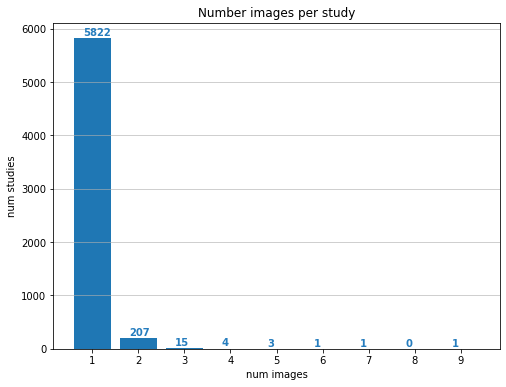

In [50]:
study_images_count = {}

for num_images in range(1, max(train_df.StudyInstanceUID.value_counts().values)+1):
    study_images_count[num_images] = np.count_nonzero(train_df.StudyInstanceUID.value_counts().values == num_images)
    
title = "Number images per study"
xlabel = "num images"
ylabel = "num studies"
fig, ax = plt.subplots(figsize=(8,6))
plot_frequency(ax, study_images_count, title, xlabel, ylabel, xgap=0.8)

<a id="section-three-four"></a>
#### **Number of bboxes per image**

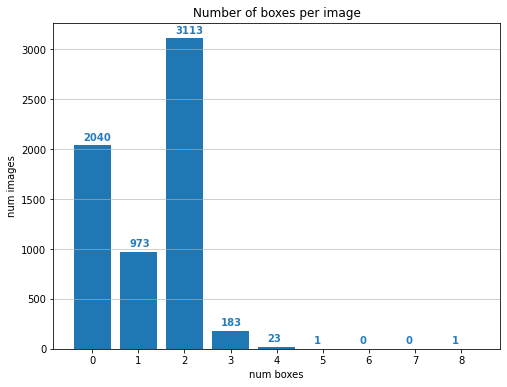

In [51]:
boxes_count = {}
for num_boxes in range(max(train_image_df['num_boxes'].unique())+1):
    if num_boxes not in train_image_df['num_boxes'].unique():
        boxes_count[num_boxes] = 0
        continue
    boxes_count[num_boxes] = len(train_image_df[train_image_df['num_boxes'] == num_boxes])

title = "Number of boxes per image"
xlabel = "num boxes"
ylabel = "num images"
fig, ax = plt.subplots(figsize=(8,6))
plot_frequency(ax, boxes_count, title, xlabel, ylabel, xgap=-0.2)

We can see the data contains 2040 null boxes, wich should mean image label is none and consider more than 3 bboxes as outliers

In [52]:
# sanity check
null_boxes = train_df[train_df['boxes'].isna()]
none_labels = train_df[train_df['image_level'] == NONE]
print("There are {} null boxes and {} none labels".format(len(null_boxes), len(none_labels)))
print("Are all null boxes with none labels? {}".format(len(np.intersect1d(train_image_df.loc[train_image_df['boxes'].isna(), 'img_id'].values, train_image_df.loc[train_image_df['image_level'] == NONE, 'img_id'].values)) == len(null_boxes.values)))

There are 2040 null boxes and 2040 none labels
Are all null boxes with none labels? True


<a id="section-three-five"></a>
#### **Study-level class frequency**

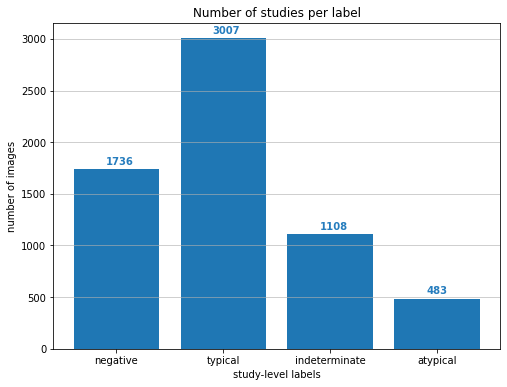

In [53]:
# check data sparsity for study
num_negatives = len(train_df[train_df[NEGATIVE] == 1])
num_typicals = len(train_df[train_df[TYPICAL] == 1])
num_indeterminates = len(train_df[train_df[INDERTEMINATE] == 1])
num_atypicals = len(train_df[train_df[ATYPICAL] == 1])

study_labels_count = {NEGATIVE:num_negatives, TYPICAL: num_typicals, 
                      INDERTEMINATE: num_indeterminates, ATYPICAL: num_atypicals}
title = "Number of studies per label"
xlabel = "study-level labels"
ylabel = "number of images"
fig, ax = plt.subplots(figsize=(8,6))

plot_frequency(ax, study_labels_count, title, xlabel, ylabel, xgap=-0.1)

<a id="section-three-six"></a>
#### **Image-level class frequency**

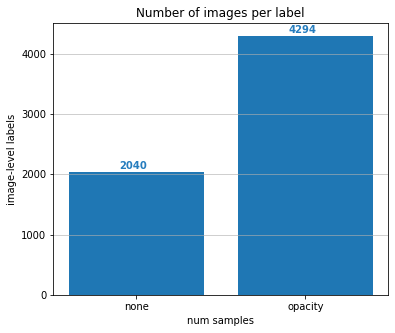

In [54]:
# check data sparsity 
num_none = len(train_image_df[train_df['image_level'] == NONE])
num_opacity = len(train_image_df[train_df['image_level'] == OPACITY])

study_labels_count = {NONE:num_none, OPACITY: num_opacity}

title = "Number of images per label"
xlabel = "num samples"
ylabel = "image-level labels"
fig, ax = plt.subplots(figsize=(6,5))
plot_frequency(ax, study_labels_count, title, xlabel, ylabel, xgap=-0.1)

<a id="section-three-seven"></a>
#### **Class distribution with no bbox**

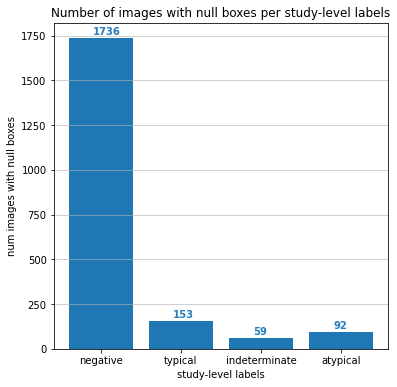

In [55]:
labels_null_boxes_count = {}

for label in study_level_labels:
    labels_null_boxes_count[label] = len(train_df[((train_df['boxes'].isna()) & (train_df[label]==1))])
    
title = "Number of images with null boxes per study-level labels"
xlabel = "study-level labels"
ylabel = "num images with null boxes"
fig, ax = plt.subplots(figsize=(6,6))
plot_frequency(ax, labels_null_boxes_count, title, xlabel, ylabel, xgap=-0.1, ygap=20)

<a id="section-three-eight"></a>
#### **Number of boxes for the different classes**

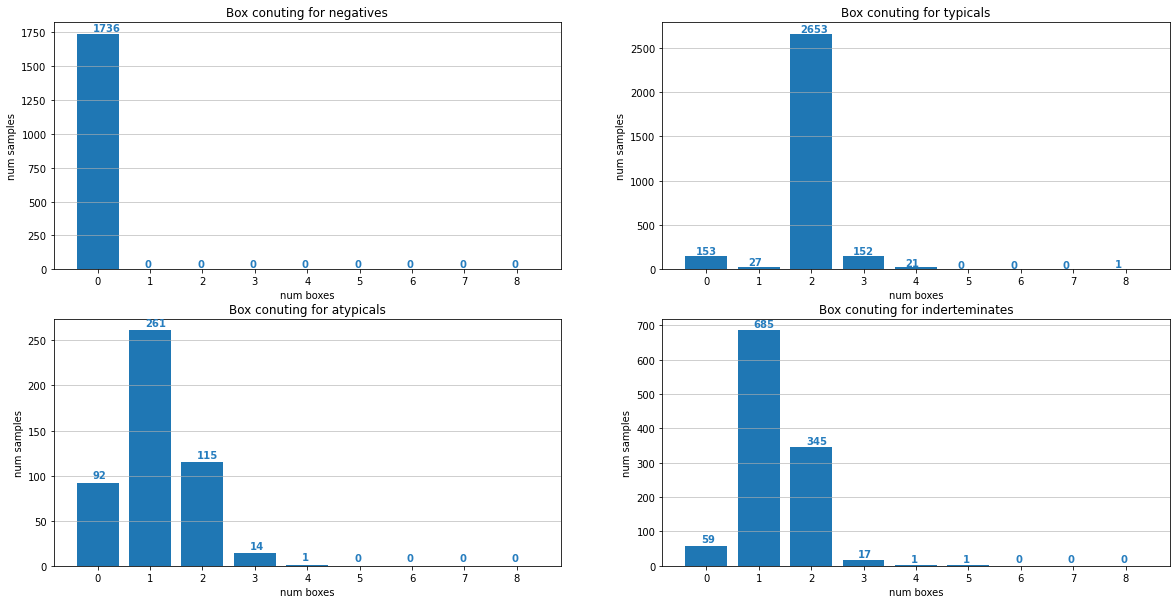

In [56]:
negatives_boxes_count = {}
typicals_boxes_count = {}
atypicals_boxes_count = {}
inderteminates_boxes_count = {}

for label in study_level_labels:
    for num_boxes in range(max(train_image_df['num_boxes'].unique())+1):
        if label == NEGATIVE:
            negatives_boxes_count[num_boxes] = len(train_df[((train_df['num_boxes'] == num_boxes) & (train_df[NEGATIVE] == 1))])
        if label == TYPICAL:
            typicals_boxes_count[num_boxes] = len(train_df[((train_df['num_boxes'] == num_boxes) & (train_df[TYPICAL] == 1))])
        if label == ATYPICAL:
            atypicals_boxes_count[num_boxes] = len(train_df[((train_df['num_boxes'] == num_boxes) & (train_df[ATYPICAL] == 1))])
        else:
            inderteminates_boxes_count[num_boxes] = len(train_df[((train_df['num_boxes'] == num_boxes) & (train_df[INDERTEMINATE] == 1))])

            
            
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
plot_frequency(axes[0,0], negatives_boxes_count, "Box conuting for negatives", "num boxes", "num samples", -0.1, 20)
plot_frequency(axes[0,1], typicals_boxes_count, "Box conuting for typicals", "num boxes", "num samples", -0.2, 20)
plot_frequency(axes[1,0], atypicals_boxes_count, "Box conuting for atypicals", "num boxes", "num samples", -0.1, 5)
plot_frequency(axes[1,1], inderteminates_boxes_count, "Box conuting for inderteminates", "num boxes", "num samples", -0.1, 10)

<a id="section-three-nine"></a>
#### **Relation between box size and number of boxes per image**

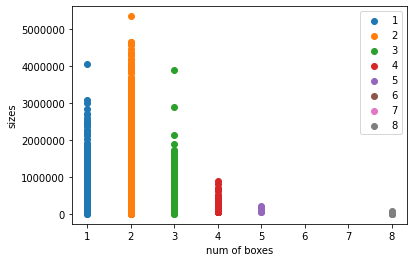

In [57]:
num_boxes = np.arange(1, max(train_image_df['num_boxes'].unique())+1)
boxes_size = {}

for key in num_boxes:
    boxes_size[key] = []

for index, row in train_image_df.iterrows():
    num_boxes = row['num_boxes']
    if num_boxes != 0:
        boxes = row['coco_boxes']
        for box in boxes:
            x,y,w,h = box
            size = w*h
            boxes_size[num_boxes].append(size)

fig, ax = plt.subplots()
for num_boxes, boxes_size in boxes_size.items():
    ax.scatter([num_boxes]*len(boxes_size), boxes_size, label=num_boxes)

ax.ticklabel_format(style='plain', useOffset=False)
plt.xlabel('num of boxes')
plt.ylabel('sizes')    
plt.legend()
plt.show()

We understand that for num_boxes > 4 the boxes size are very small and those are outliers

In [58]:
train_df = train_df[train_df['num_boxes'] < 4]

<a id="section-four"></a>
## **DICOM files**

<a id="section-four-one"></a>
#### **View dicom files metadata**

In [59]:
pydicom.dcmread(train_df.loc[0, 'dicom_path'])

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.135099524260102611886915167296699866712
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 000a312787f2
(0008, 0020) Study Date                          DA: '526316e376d4'
(0008, 0030) Study Time                          TM: '8ccfb6acf07f'
(0008, 0050) Accession Number                    SH: 'f6cd7f2019f5'
(0008, 0060) Modality                            CS: 'DX'
(0010, 0010) Patient's Name                      PN: 'd4268f26ed05'
(

<a id="section-four-two"></a>
#### **Add metadata and image shape to train df**

In [60]:
def get_img(path):
        data_file = pydicom.dcmread(path)
        img = apply_voi_lut(data_file.pixel_array, data_file)
        #img = data_file.pixel_array.astype(float)

        if data_file.PhotometricInterpretation == "MONOCHROME1":
            img = np.amax(img) - img

        # Rescaling grey scale between 0-255 and convert to uint
        img = img - np.min(img)
        img = img / np.max(img)
        img = (img * 255).astype(np.uint8)

        return img

def get_img_id(path):
        return path.split('/')[-1].split('.')[0] # extract img_id from path

In [61]:
def get_observation_data(path):
    image_data = pydicom.read_file(path)
    img_id = get_img_id(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "img_id": img_id,
        "Rows" : image_data.get("Rows"),
        "Columns" : image_data.get("Columns"),
        "SOPClassUID" : image_data.get("SOPClassUID"),
        "SOPInstanceUID" : image_data.get("SOPInstanceUID"),
        "PatientID" : image_data.get("PatientID"),
        "PatientName" : image_data.get("PatientName"),
        "PatientSex" : image_data.get("PatientSex"),
        "PhotometricInterpretation" : image_data.get("PhotometricInterpretation"),
        "StudyInstanceUID" : image_data.get("StudyInstanceUID"),
        "SamplesPerPixel" : image_data.get("SamplesPerPixel"),
        "BitsAllocated" : image_data.get("BitsAllocated"),
        "BitsStored" : image_data.get("BitsStored"),
        "HighBit" : image_data.get("HighBit"),
        "PixelRepresentation" : image_data.get("PixelRepresentation"),
    }

    # String columns
    str_columns = ["ImageType", "Modality", "PatientSex", "BodyPartExamined"]
    for i in str_columns:
        observation_data[i] = str(image_data.get(i)) if i in image_data else None
        
    return observation_data

In [62]:
metadata = {}
shapes = []

for index, row in train_df.iterrows():
    metadata[index] = get_observation_data(row['dicom_path'])
    img = get_img(row['dicom_path'])
    shapes.append(img.shape)

train_df['original_shape'] = shapes

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


In [63]:
metadata_df = pd.DataFrame(metadata)
# swap the columns with indexes
metadata_df = metadata_df.transpose()

In [64]:
metadata_df.head()

,img_id,Rows,Columns,SOPClassUID,SOPInstanceUID,PatientID,PatientName,PatientSex,PhotometricInterpretation,StudyInstanceUID,SamplesPerPixel,BitsAllocated,BitsStored,HighBit,PixelRepresentation,ImageType,Modality,BodyPartExamined
0,000a312787f2,3488,4256,71228e4340de,000a312787f2,dcc3fdf6426a,"(d, 4, 2, 6, 8, f, 2, 6, e, d, 0, 5)",M,MONOCHROME2,5776db0cec75,1,16,12,11,0,"['ORIGINAL', 'PRIMARY']",DX,CHEST
1,000c3a3f293f,2320,2832,03a65300fa41,000c3a3f293f,f09ff9b7dab3,"(e, f, 8, c, 3, 1, f, 8, d, f, d, d)",M,MONOCHROME2,ff0879eb20ed,1,8,8,7,0,"['ORIGINAL', 'PRIMARY']",CR,CHEST
2,0012ff7358bc,2544,3056,71228e4340de,0012ff7358bc,6a02c0731039,"(2, f, 2, f, b, 9, 4, 4, f, e, 4, 4)",F,MONOCHROME2,9d514ce429a7,1,16,12,11,0,"['DERIVED', 'PRIMARY']",DX,PORT CHEST
3,001398f4ff4f,3520,4280,03a65300fa41,001398f4ff4f,db63d9b7f61c,"(9, c, c, d, 8, 7, b, 4, 5, 1, 1, b)",F,MONOCHROME1,28dddc8559b2,1,16,12,11,0,"['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT',...",CR,CHEST
4,001bd15d1891,2800,3408,71228e4340de,001bd15d1891,605693f36f43,"(3, 5, b, f, 9, d, d, b, f, 9, e, 9)",M,MONOCHROME1,dfd9fdd85a3e,1,16,15,14,0,"['ORIGINAL', 'PRIMARY']",DX,CHEST


In [65]:
# verify read meta data of all images
train_ids = np.array(train_df['img_id'].values) 
metadata_ids = np.array(metadata_df['img_id'].values)
len(np.setdiff1d(train_ids,metadata_ids))

0

In [66]:
metadata_df.to_csv(os.path.join(output_path, 'images_metadata.csv'), index=False)
#metadata_df = pd.read_csv(metadata_path)

In [67]:
# merge metadata and train df
train_df = pd.merge(train_df, metadata_df, how='inner', on=['img_id'])
train_df.head()

,img_id,boxes,StudyInstanceUID_x,image_level,confidence_scores,pascal_voc_boxes,coco_boxes,num_boxes,dicom_path,negative,...,PhotometricInterpretation,StudyInstanceUID_y,SamplesPerPixel,BitsAllocated,BitsStored,HighBit,PixelRepresentation,ImageType,Modality,BodyPartExamined
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",5776db0cec75,opacity,"[1.0, 1.0]","[[789.28836, 582.43035, 1815.94498, 2499.73327...","[[789.28836, 582.43035, 1026.65662, 1917.30292...",2,../input/siim-covid19-detection/train/5776db0c...,0,...,MONOCHROME2,5776db0cec75,1,16,12,11,0,"['ORIGINAL', 'PRIMARY']",DX,CHEST
1,000c3a3f293f,NaN,ff0879eb20ed,none,[1.0],"[[0.0, 0.0, 1.0, 1.0]]",NaN,0,../input/siim-covid19-detection/train/ff0879eb...,1,...,MONOCHROME2,ff0879eb20ed,1,8,8,7,0,"['ORIGINAL', 'PRIMARY']",CR,CHEST
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",9d514ce429a7,opacity,"[1.0, 1.0]","[[677.42216, 197.97662, 1545.21983, 1197.75876...","[[677.42216, 197.97662, 867.79767, 999.78214],...",2,../input/siim-covid19-detection/train/9d514ce4...,0,...,MONOCHROME2,9d514ce429a7,1,16,12,11,0,"['DERIVED', 'PRIMARY']",DX,PORT CHEST
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",28dddc8559b2,opacity,[1.0],"[[2729.0, 2181.33331, 3677.00012, 2785.33331]]","[[2729.0, 2181.33331, 948.00012, 604.0]]",1,../input/siim-covid19-detection/train/28dddc85...,0,...,MONOCHROME1,28dddc8559b2,1,16,12,11,0,"['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT',...",CR,CHEST
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",dfd9fdd85a3e,opacity,"[1.0, 1.0]","[[623.23328, 1050.0, 1337.23328, 2156.0], [257...","[[623.23328, 1050.0, 714.0, 1106.0], [2578.566...",2,../input/siim-covid19-detection/train/dfd9fdd8...,0,...,MONOCHROME1,dfd9fdd85a3e,1,16,15,14,0,"['ORIGINAL', 'PRIMARY']",DX,CHEST


In [68]:
train_df = train_df.drop(columns=['StudyInstanceUID_y']).rename(columns = {'StudyInstanceUID_x': 'StudyInstanceUID'})
train_df.head()

,img_id,boxes,StudyInstanceUID,image_level,confidence_scores,pascal_voc_boxes,coco_boxes,num_boxes,dicom_path,negative,...,PatientSex,PhotometricInterpretation,SamplesPerPixel,BitsAllocated,BitsStored,HighBit,PixelRepresentation,ImageType,Modality,BodyPartExamined
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",5776db0cec75,opacity,"[1.0, 1.0]","[[789.28836, 582.43035, 1815.94498, 2499.73327...","[[789.28836, 582.43035, 1026.65662, 1917.30292...",2,../input/siim-covid19-detection/train/5776db0c...,0,...,M,MONOCHROME2,1,16,12,11,0,"['ORIGINAL', 'PRIMARY']",DX,CHEST
1,000c3a3f293f,NaN,ff0879eb20ed,none,[1.0],"[[0.0, 0.0, 1.0, 1.0]]",NaN,0,../input/siim-covid19-detection/train/ff0879eb...,1,...,M,MONOCHROME2,1,8,8,7,0,"['ORIGINAL', 'PRIMARY']",CR,CHEST
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",9d514ce429a7,opacity,"[1.0, 1.0]","[[677.42216, 197.97662, 1545.21983, 1197.75876...","[[677.42216, 197.97662, 867.79767, 999.78214],...",2,../input/siim-covid19-detection/train/9d514ce4...,0,...,F,MONOCHROME2,1,16,12,11,0,"['DERIVED', 'PRIMARY']",DX,PORT CHEST
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",28dddc8559b2,opacity,[1.0],"[[2729.0, 2181.33331, 3677.00012, 2785.33331]]","[[2729.0, 2181.33331, 948.00012, 604.0]]",1,../input/siim-covid19-detection/train/28dddc85...,0,...,F,MONOCHROME1,1,16,12,11,0,"['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT',...",CR,CHEST
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",dfd9fdd85a3e,opacity,"[1.0, 1.0]","[[623.23328, 1050.0, 1337.23328, 2156.0], [257...","[[623.23328, 1050.0, 714.0, 1106.0], [2578.566...",2,../input/siim-covid19-detection/train/dfd9fdd8...,0,...,M,MONOCHROME1,1,16,15,14,0,"['ORIGINAL', 'PRIMARY']",DX,CHEST


<a id="section-five"></a>
## **Explore images**

In [69]:
def get_study_label(sample):
    if sample[NEGATIVE].values[0] == 1:
        return NEGATIVE
    if sample[TYPICAL].values[0] == 1:
        return TYPICAL
    if sample[INDERTEMINATE].values[0] == 1:
        return INDERTEMINATE
    return ATYPICAL

In [70]:
studies_per_imgs_count = {}
imgs_paths = {}
imgs_count = train_df.StudyInstanceUID.value_counts()

for num_images in range(2,10):
    studies_per_imgs_count[num_images] = imgs_count.where(imgs_count == num_images).dropna().keys()

for num_images, studies in studies_per_imgs_count.items():
    study_paths = {}
    for study in studies:
        paths = []
        for root, d_names, f_names in os.walk(os.path.join(train_path,study)):
            for f in f_names:
                studies_per_imgs_count[num_images]
                paths.append(os.path.join(root, f))
        study_paths[study] = paths
        
    imgs_paths[num_images] = study_paths

In [71]:
def show_studies_imgs_by_num_img(df, studies, num_images, figsize):
    fig, axes = plt.subplots(nrows=len(studies), ncols=num_images, figsize=figsize) 
    colors = {TYPICAL: (0,0,255), INDERTEMINATE: (0,255,0), ATYPICAL: (255,0,0)} # negatives have no boxes
    print("Typical: "+colored("Blue","blue")+"\nInderteminate: "+colored("Green","green")+"\nAtypical: "+colored("Red", "red"))
            
    for row, (study, paths) in enumerate(studies.items()):
        for col, path in enumerate(paths):
            img_id = get_img_id(path)
            img = get_img(path)
            # create new RGB image from original
            new_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=img.dtype)
            new_img[:,:,:] = img[:,:,np.newaxis]
            row_df = df[df['img_id'] == img_id]
            study_label = get_study_label(row_df)
            
            if row_df['image_level'].values[0] != NONE:
                for box in df['pascal_voc_boxes'].values[0]:
                    xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
                    new_img = cv2.rectangle(new_img,(xmin,ymin),(xmax,ymax),colors[study_label],20)

            if len(studies) > 1:
                axes[row,col].set_title("Study: {}\nImage ID: {}\nLabel: {}".format(study, img_id, study_label))
                axes[row,col].imshow(new_img)
            else:
                axes[col].set_title("Study: {}\nImage ID: {}\nLabel: {}".format(study, img_id, study_label))
                axes[col].imshow(new_img)

<a id="section-five-one"></a>
#### **Number of images per study**

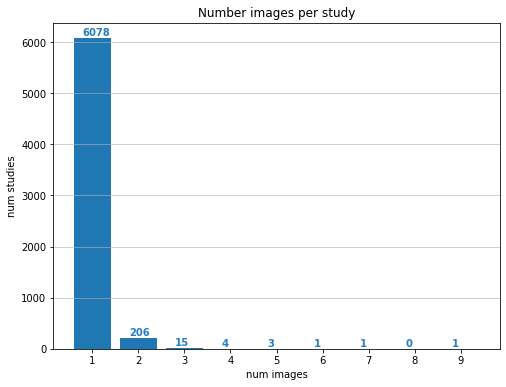

In [72]:
study_count = {}
total_with_more_than_one = 0

for num_imgs,studies in imgs_paths.items():
    study_count[num_imgs] = len(studies)
    total_with_more_than_one += len(studies)

study_count[1] = len(train_df) - total_with_more_than_one

# sort dict by count
study_count = dict(sorted(study_count.items()))

title = "Number images per study"
xlabel = "num images"
ylabel = "num studies"
fig, ax = plt.subplots(figsize=(8,6))
plot_frequency(ax, study_count, title, xlabel, ylabel, xgap=0.8)

Let's explore studies with more than 1 image

<a id="section-five-two"></a>
#### **Studies with 3 images**

Typical: Blue
Inderteminate: Green
Atypical: Red


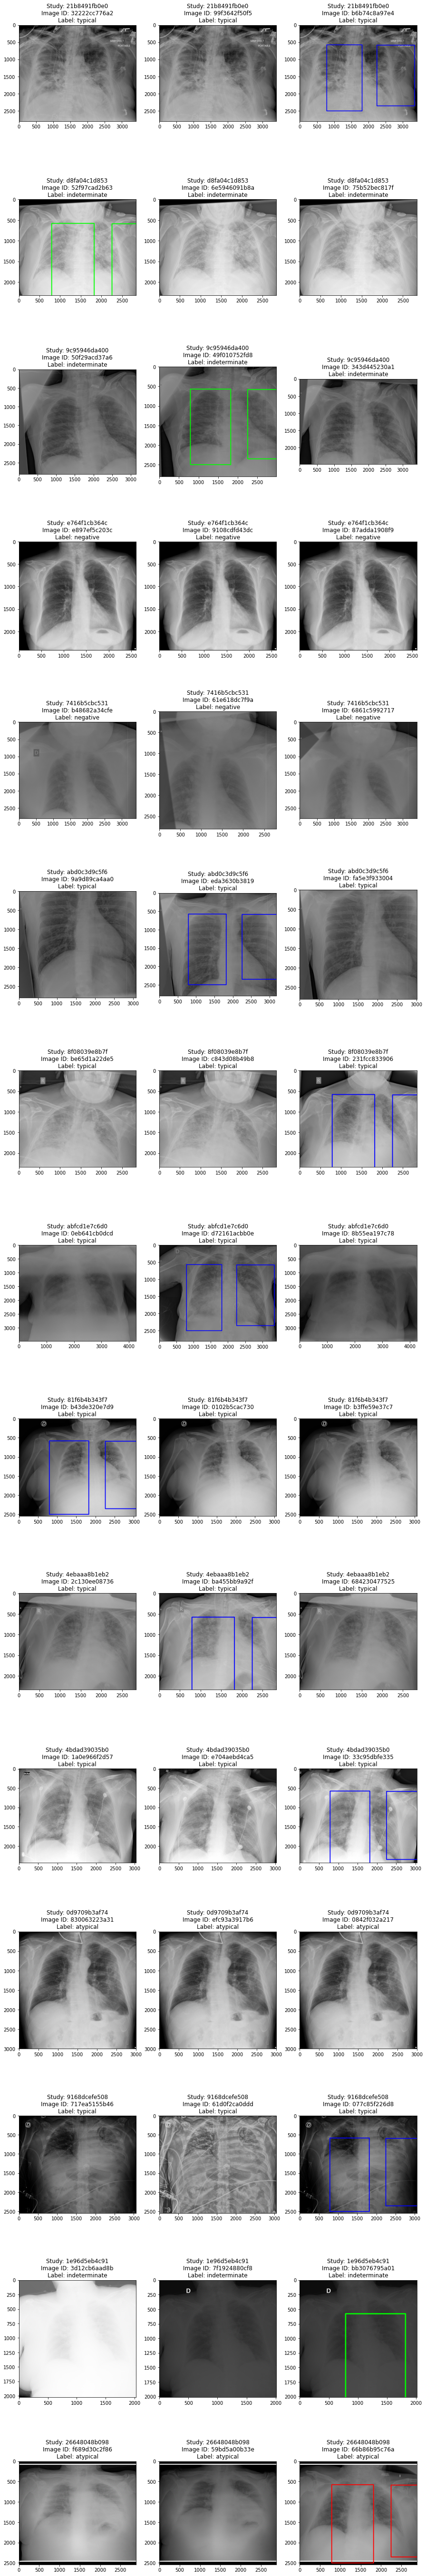

In [54]:
show_studies_imgs_by_num_img(train_df, imgs_paths[3], 3, (15,100))

We can see in each study the images are the same and those wh have an image with a bounding box, just one of the images contains it, even though it's the same image. </br>
Remove images without bbox

In [73]:
imgs_paths[3].keys()

dict_keys(['1e96d5eb4c91', '7416b5cbc531', '0d9709b3af74', 'abd0c3d9c5f6', 'abfcd1e7c6d0', 'e764f1cb364c', '9168dcefe508', '4bdad39035b0', '4ebaaa8b1eb2', '9c95946da400', '21b8491fb0e0', '8f08039e8b7f', '81f6b4b343f7', '26648048b098', 'd8fa04c1d853'])

In [74]:
studies_without_bbox = ['e764f1cb364c', '0d9709b3af74', '7416b5cbc531']
studies_with_bbox = [study for study in list(imgs_paths[3].keys()) if study not in studies_without_bbox]

print(len(list(imgs_paths[3].keys())) == (len(studies_with_bbox)+len(studies_without_bbox)))

True


In [57]:
def compare_columns(studies, num_imgs):
    study_imgs = {}

    for study in studies:
        rows = train_df[train_df['StudyInstanceUID']==study]
        study_imgs[study] = rows.to_dict(orient='records')

    for study, samples in study_imgs.items():
        print("\033[1mStudy: {}\n\033[0m".format(study))
        for key in list(samples[0].keys()):
            values = [samples[i][key] for i in range(num_imgs)]
            print("\033[1m{}:\033[0m".format(key))
            for value in values:
                print(value)
            print()
        print("------------------------------------------------------------------------------------------------------------------------------------------")
    
compare_columns(studies_with_bbox, 3)

Study: 21b8491fb0e0

img_id:
32222cc776a2
99f3642f50f5
b6b74c8a97e4

boxes:
nan
nan
[{'x': 288.54139, 'y': 1154.24689, 'width': 998.8675, 'height': 1046.43274}, {'x': 2004.05669, 'y': 1043.26161, 'width': 675.42456, 'height': 1036.91956}]

StudyInstanceUID:
21b8491fb0e0
21b8491fb0e0
21b8491fb0e0

image_level:
none
none
opacity

confidence_scores:
[1.0]
[1.0]
[1.0, 1.0]

pascal_voc_boxes:
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[288.54139, 1154.24689, 1287.40889, 2200.6796299999996], [2004.05669, 1043.26161, 2679.48125, 2080.18117]]

coco_boxes:
nan
nan
[[288.54139, 1154.24689, 998.8675, 1046.43274], [2004.05669, 1043.26161, 675.42456, 1036.91956]]

num_boxes:
0
0
2

dicom_path:
../input/siim-covid19-detection/train/21b8491fb0e0/d5832b266b40/32222cc776a2.dcm
../input/siim-covid19-detection/train/21b8491fb0e0/d5832b266b40/99f3642f50f5.dcm
../input/siim-covid19-detection/train/21b8491fb0e0/d5832b266b40/b6b74c8a97e4.dcm

negative:
0
0
0

typical:
1
1
1

indeterminate:
0
0
0

atypica

We can see all images of the same study has the same PatientID and PatientName and is the same scan, so we choose to keep only the one image with the bbox.

In [75]:
def drop_imgs_without_bbox(studies, df):
    rows_to_drop = []
    for study in studies:
        rows = df[df['StudyInstanceUID']==study]
        for row in rows.loc[rows['num_boxes']==0].index:
            rows_to_drop.append(row)
    
    return df.drop(labels=rows_to_drop, axis=0)

train_df = drop_imgs_without_bbox(studies_with_bbox, train_df)

Check the differences between images of same study without bounding box

In [59]:
compare_columns(studies_without_bbox, 3)

Study: e764f1cb364c

img_id:
87adda1908f9
9108cdfd43dc
e897ef5c203c

boxes:
nan
nan
nan

StudyInstanceUID:
e764f1cb364c
e764f1cb364c
e764f1cb364c

image_level:
none
none
none

confidence_scores:
[1.0]
[1.0]
[1.0]

pascal_voc_boxes:
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]

coco_boxes:
nan
nan
nan

num_boxes:
0
0
0

dicom_path:
../input/siim-covid19-detection/train/e764f1cb364c/4bbd0e9a1ba2/87adda1908f9.dcm
../input/siim-covid19-detection/train/e764f1cb364c/6ed04fa3ce03/9108cdfd43dc.dcm
../input/siim-covid19-detection/train/e764f1cb364c/02a46123a5cb/e897ef5c203c.dcm

negative:
1
1
1

typical:
0
0
0

indeterminate:
0
0
0

atypical:
0
0
0

study_level:
negative
negative
negative

int_label:
0
0
0

original_shape:
(2418, 2606)
(2418, 2606)
(2418, 2606)

Rows:
2418
2418
2418

Columns:
2606
2606
2606

SOPClassUID:
03a65300fa41
03a65300fa41
03a65300fa41

SOPInstanceUID:
87adda1908f9
9108cdfd43dc
e897ef5c203c

PatientID:
e746c9c7e297
e746c9c7e297
e746c9c7e297

Patie

they are all duplicates, we choose to keep only one of them

In [76]:
def drop_duplicate_imgs(studies, df, num_imgs):
    rows_to_drop = []
    for study in studies:
        rows = df[df['StudyInstanceUID']==study]
        for i, row in enumerate(rows.index):
            if i%num_imgs!=0:
                rows_to_drop.append(row)
                
    return df.drop(labels=rows_to_drop, axis=0)

train_df = drop_duplicate_imgs(studies_without_bbox, train_df, 3)

We can see all columns have same values, except num_boxes

<a id="section-five-three"></a>
#### **Studies with 4 images**

Typical: Blue
Inderteminate: Green
Atypical: Red


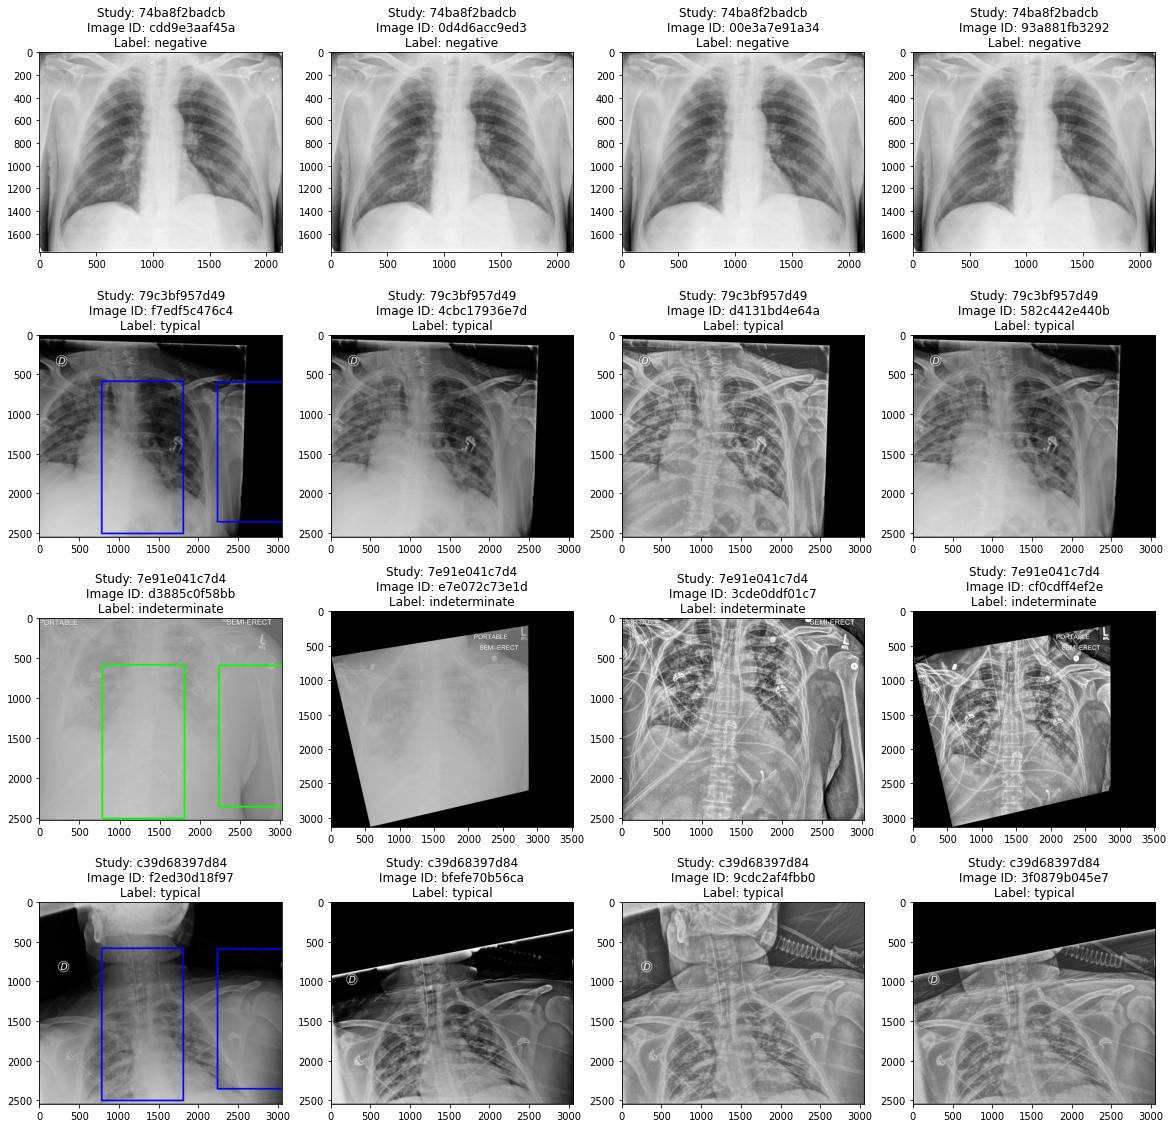

In [61]:
show_studies_imgs_by_num_img(train_df, imgs_paths[4], 4, (20,20))

In [77]:
imgs_paths[4].keys()

dict_keys(['74ba8f2badcb', '7e91e041c7d4', '79c3bf957d49', 'c39d68397d84'])

In [78]:
studies_without_bbox = ['74ba8f2badcb']
studies_with_bbox = [study for study in list(imgs_paths[4].keys()) if study not in studies_without_bbox]

print(len(list(imgs_paths[4].keys())) == (len(studies_with_bbox)+len(studies_without_bbox)))

True


In [64]:
compare_columns(studies_with_bbox, 4)

Study: 79c3bf957d49

img_id:
4cbc17936e7d
582c442e440b
d4131bd4e64a
f7edf5c476c4

boxes:
nan
nan
nan
[{'x': 17.73449, 'y': 529.06195, 'width': 945.55754, 'height': 1302.01764}, {'x': 1282.23007, 'y': 570.33628, 'width': 791.71692, 'height': 1504.63708}]

StudyInstanceUID:
79c3bf957d49
79c3bf957d49
79c3bf957d49
79c3bf957d49

image_level:
none
none
none
opacity

confidence_scores:
[1.0]
[1.0]
[1.0]
[1.0, 1.0]

pascal_voc_boxes:
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[17.73449, 529.06195, 963.2920300000001, 1831.07959], [1282.23007, 570.33628, 2073.94699, 2074.97336]]

coco_boxes:
nan
nan
nan
[[17.73449, 529.06195, 945.55754, 1302.01764], [1282.23007, 570.33628, 791.71692, 1504.63708]]

num_boxes:
0
0
0
2

dicom_path:
../input/siim-covid19-detection/train/79c3bf957d49/fb07235d8e4f/4cbc17936e7d.dcm
../input/siim-covid19-detection/train/79c3bf957d49/3c6987e96032/582c442e440b.dcm
../input/siim-covid19-detection/train/79c3bf957d49/02687bf3a14f/d4131bd4e64a.dcm
.

like before, for each study we keep only one image- the one with the bbox

In [79]:
train_df = drop_imgs_without_bbox(studies_with_bbox, train_df)

Check the differences between images of same study without bounding box

In [66]:
compare_columns(studies_without_bbox, 4)

Study: 74ba8f2badcb

img_id:
00e3a7e91a34
0d4d6acc9ed3
93a881fb3292
cdd9e3aaf45a

boxes:
nan
nan
nan
nan

StudyInstanceUID:
74ba8f2badcb
74ba8f2badcb
74ba8f2badcb
74ba8f2badcb

image_level:
none
none
none
none

confidence_scores:
[1.0]
[1.0]
[1.0]
[1.0]

pascal_voc_boxes:
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]

coco_boxes:
nan
nan
nan
nan

num_boxes:
0
0
0
0

dicom_path:
../input/siim-covid19-detection/train/74ba8f2badcb/c8755f476425/00e3a7e91a34.dcm
../input/siim-covid19-detection/train/74ba8f2badcb/b9e7a4279b83/0d4d6acc9ed3.dcm
../input/siim-covid19-detection/train/74ba8f2badcb/6452802696f6/93a881fb3292.dcm
../input/siim-covid19-detection/train/74ba8f2badcb/51da3f27b9a8/cdd9e3aaf45a.dcm

negative:
1
1
1
1

typical:
0
0
0
0

indeterminate:
0
0
0
0

atypical:
0
0
0
0

study_level:
negative
negative
negative
negative

int_label:
0
0
0
0

original_shape:
(1760, 2140)
(1760, 2140)
(1760, 2140)
(1760, 2140)

Rows:
1760
1760
1760
1760

Co

Again, the images are duplicate- keep only one image per study

In [80]:
train_df = drop_duplicate_imgs(studies_without_bbox, train_df, 4)

<a id="section-five-four"></a>
#### **Studies with 5 images**

Typical: Blue
Inderteminate: Green
Atypical: Red


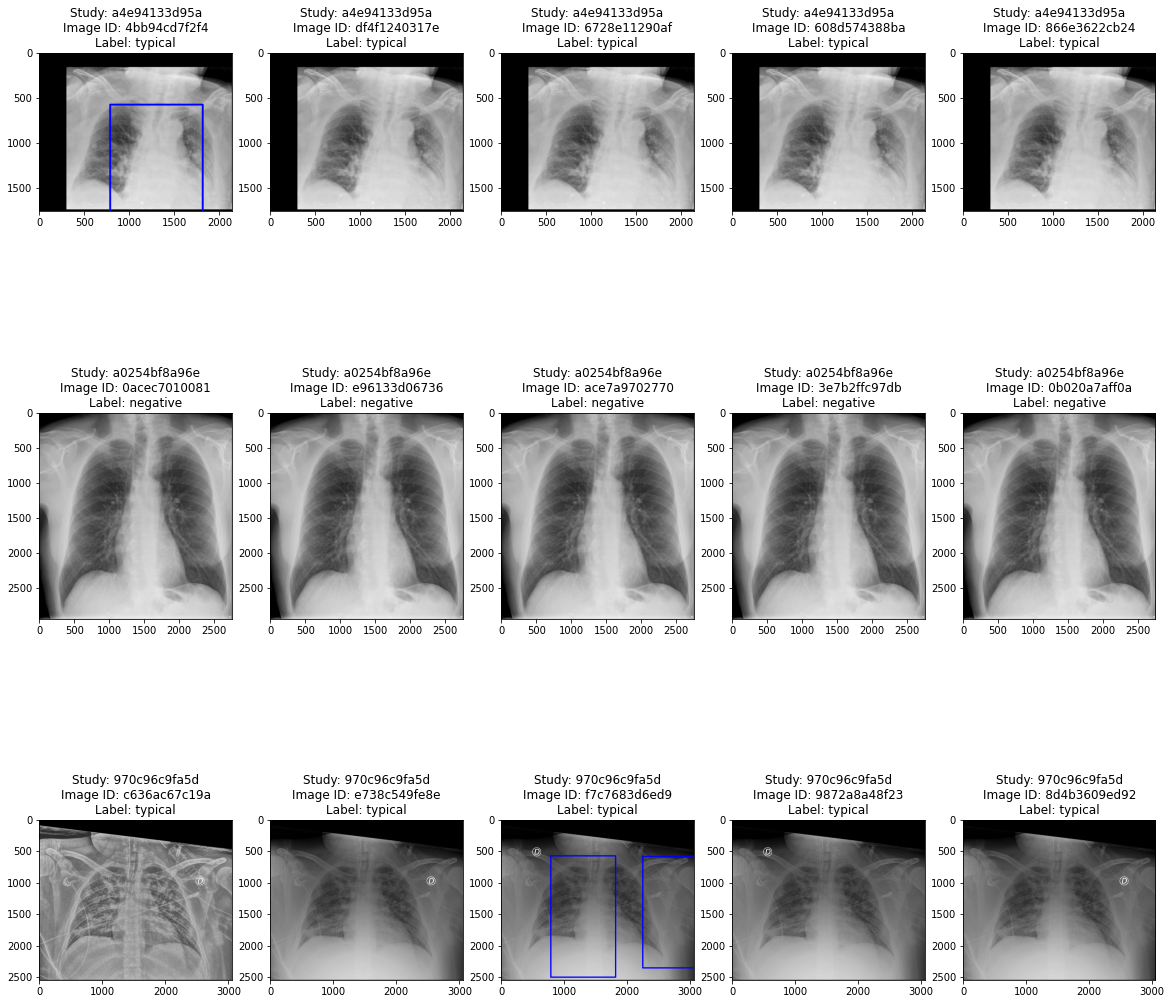

In [68]:
show_studies_imgs_by_num_img(train_df, imgs_paths[5], 5, (20,20))

In [81]:
imgs_paths[5].keys()

dict_keys(['a0254bf8a96e', '970c96c9fa5d', 'a4e94133d95a'])

In [82]:
studies_without_bbox = ['a0254bf8a96e']
studies_with_bbox = [study for study in list(imgs_paths[5].keys()) if study not in studies_without_bbox]

print(len(list(imgs_paths[5].keys())) == (len(studies_with_bbox)+len(studies_without_bbox)))

True


In [71]:
compare_columns(studies_with_bbox, 5)

Study: a4e94133d95a

img_id:
4bb94cd7f2f4
608d574388ba
6728e11290af
866e3622cb24
df4f1240317e

boxes:
[{'x': 1532.51505, 'y': 781.35382, 'width': 424.80066, 'height': 849.60138}, {'x': 450.0732, 'y': 916.43694, 'width': 479.90033, 'height': 646.97668}]
nan
nan
nan
nan

StudyInstanceUID:
a4e94133d95a
a4e94133d95a
a4e94133d95a
a4e94133d95a
a4e94133d95a

image_level:
opacity
none
none
none
none

confidence_scores:
[1.0, 1.0]
[1.0]
[1.0]
[1.0]
[1.0]

pascal_voc_boxes:
[[1532.51505, 781.35382, 1957.3157099999999, 1630.9551999999999], [450.0732, 916.43694, 929.97353, 1563.41362]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]

coco_boxes:
[[1532.51505, 781.35382, 424.80066, 849.60138], [450.0732, 916.43694, 479.90033, 646.97668]]
nan
nan
nan
nan

num_boxes:
2
0
0
0
0

dicom_path:
../input/siim-covid19-detection/train/a4e94133d95a/80e588304042/4bb94cd7f2f4.dcm
../input/siim-covid19-detection/train/a4e94133d95a/8f9beb80ef97/608d574388ba.dcm
../input

In [83]:
train_df = drop_imgs_without_bbox(studies_with_bbox, train_df)

In [73]:
compare_columns(studies_without_bbox, 5)

Study: a0254bf8a96e

img_id:
0acec7010081
0b020a7aff0a
3e7b2ffc97db
ace7a9702770
e96133d06736

boxes:
nan
nan
nan
nan
nan

StudyInstanceUID:
a0254bf8a96e
a0254bf8a96e
a0254bf8a96e
a0254bf8a96e
a0254bf8a96e

image_level:
none
none
none
none
none

confidence_scores:
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]

pascal_voc_boxes:
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]

coco_boxes:
nan
nan
nan
nan
nan

num_boxes:
0
0
0
0
0

dicom_path:
../input/siim-covid19-detection/train/a0254bf8a96e/1d3998721a2a/0acec7010081.dcm
../input/siim-covid19-detection/train/a0254bf8a96e/06ba74679242/0b020a7aff0a.dcm
../input/siim-covid19-detection/train/a0254bf8a96e/28087c35914d/3e7b2ffc97db.dcm
../input/siim-covid19-detection/train/a0254bf8a96e/6a0d1a7615db/ace7a9702770.dcm
../input/siim-covid19-detection/train/a0254bf8a96e/4fef6386ea44/e96133d06736.dcm

negative:
1
1
1
1
1

typical:
0
0
0
0
0

indeterminate:
0
0
0
0
0

atypical:
0
0
0
0
0

study_lev

In [84]:
train_df = drop_duplicate_imgs(studies_without_bbox, train_df, 5)

<a id="section-five-five"></a>
#### **Studies with 6 images**

Typical: Blue
Inderteminate: Green
Atypical: Red


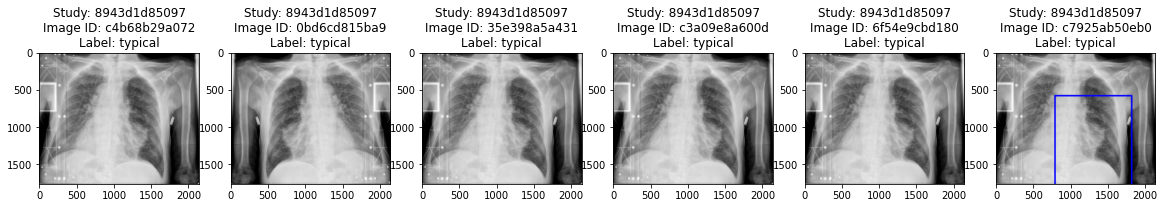

In [75]:
show_studies_imgs_by_num_img(train_df, imgs_paths[6], 6, (20,20))

In [85]:
imgs_paths[6].keys()

dict_keys(['8943d1d85097'])

In [86]:
studies_with_bbox = ['8943d1d85097']

print(len(list(imgs_paths[6].keys())) == (len(studies_with_bbox)))

True


In [78]:
compare_columns(studies_with_bbox, 6)

Study: 8943d1d85097

img_id:
0bd6cd815ba9
35e398a5a431
6f54e9cbd180
c3a09e8a600d
c4b68b29a072
c7925ab50eb0

boxes:
nan
nan
nan
nan
nan
[{'x': 1265.90376, 'y': 571.61961, 'width': 373.25574, 'height': 814.0531}, {'x': 238.56157, 'y': 463.19773, 'width': 332.37544, 'height': 796.27902}]

StudyInstanceUID:
8943d1d85097
8943d1d85097
8943d1d85097
8943d1d85097
8943d1d85097
8943d1d85097

image_level:
none
none
none
none
none
opacity

confidence_scores:
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]
[1.0, 1.0]

pascal_voc_boxes:
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[0.0, 0.0, 1.0, 1.0]]
[[1265.90376, 571.61961, 1639.1595, 1385.6727099999998], [238.56157, 463.19773, 570.93701, 1259.4767499999998]]

coco_boxes:
nan
nan
nan
nan
nan
[[1265.90376, 571.61961, 373.25574, 814.0531], [238.56157, 463.19773, 332.37544, 796.27902]]

num_boxes:
0
0
0
0
0
2

dicom_path:
../input/siim-covid19-detection/train/8943d1d85097/b9820b7c6b80/0bd6cd815ba9.dcm
../input/siim-covid

In [87]:
train_df = drop_imgs_without_bbox(studies_with_bbox, train_df)

<a id="section-five-six"></a>
#### **Studies with 7 images**

Typical: Blue
Inderteminate: Green
Atypical: Red


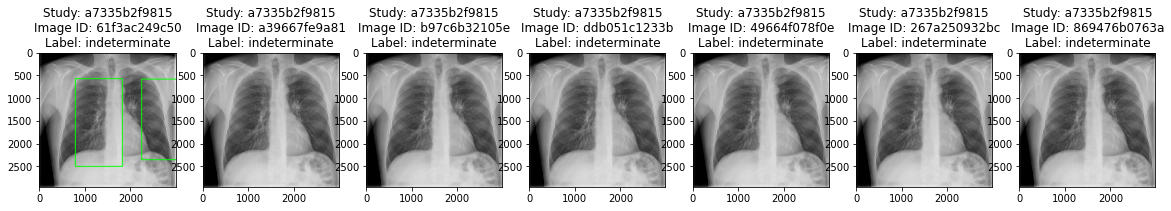

In [80]:
show_studies_imgs_by_num_img(train_df, imgs_paths[7], 7, (20,20))

In [88]:
imgs_paths[7].keys()

dict_keys(['a7335b2f9815'])

In [89]:
studies_with_bbox = ['a7335b2f9815']

print(len(list(imgs_paths[7].keys())) == (len(studies_with_bbox)))

True


In [90]:
train_df = drop_imgs_without_bbox(studies_with_bbox, train_df)

<a id="section-five-seven"></a>
#### **Studies with 9 images**

Typical: Blue
Inderteminate: Green
Atypical: Red


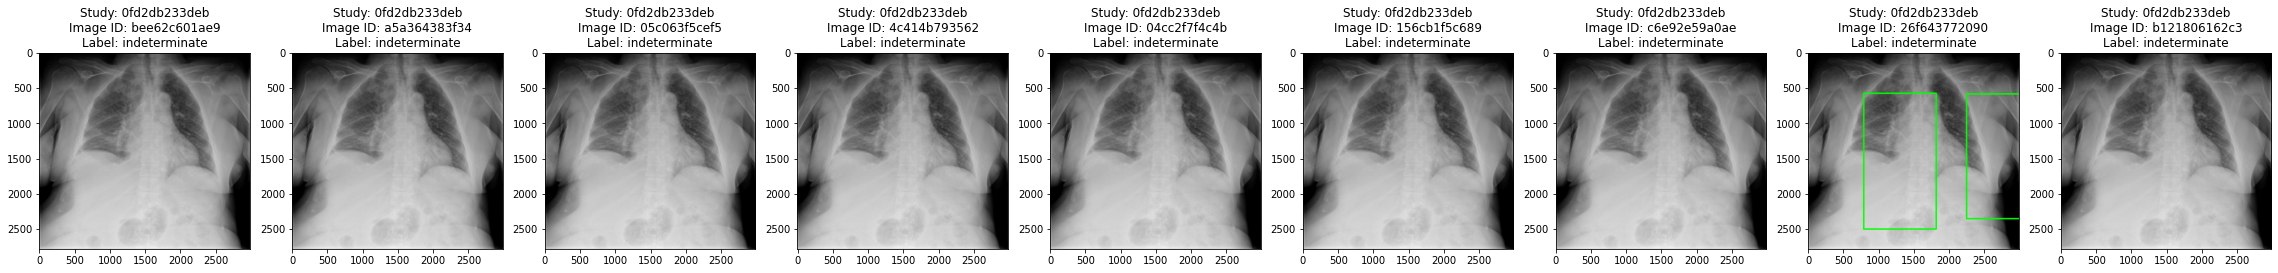

In [84]:
show_studies_imgs_by_num_img(train_df, imgs_paths[9], 9, (40,20))

In [91]:
imgs_paths[9].keys()

dict_keys(['0fd2db233deb'])

In [92]:
studies_with_bbox = ['0fd2db233deb']

print(len(list(imgs_paths[9].keys())) == (len(studies_with_bbox)))

True


In [93]:
train_df = drop_imgs_without_bbox(studies_with_bbox, train_df)

<a id="section-five-eight"></a>
#### **Studies with 2 images**

there are 206 studies with 2 images, instead of checking each study we assume the same pattern for them- duplicates, when both don't have any bbox or one of them have

In [94]:
rows_to_drop = []

for study, samples in imgs_paths[2].items():
    rows = train_df[train_df['StudyInstanceUID']==study]
    sample1= rows.iloc[0]
    sample2 = rows.iloc[1]
    if sample1['PatientID'] == sample2['PatientID']:  # if same patient id (duplicate)
        if sample1['num_boxes'] != sample2['num_boxes']: # if not same number of bounding boxes
            rows_to_drop.append(rows.loc[rows['num_boxes']==0].index.values[0]) # keep image with bounding box
        if sample1['num_boxes'] == sample2['num_boxes']: # if same number of boxes (probably no boxes)
            rows_to_drop.append(rows.loc[rows['img_id']==sample1['img_id']].index.values[0]) # keep only one of them (sample2)

In [95]:
train_df = train_df.drop(labels=rows_to_drop, axis=0)

Check null boxes after "cleaning" the data

In [96]:
train_df.head()

,img_id,boxes,StudyInstanceUID,image_level,confidence_scores,pascal_voc_boxes,coco_boxes,num_boxes,dicom_path,negative,...,PatientSex,PhotometricInterpretation,SamplesPerPixel,BitsAllocated,BitsStored,HighBit,PixelRepresentation,ImageType,Modality,BodyPartExamined
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",5776db0cec75,opacity,"[1.0, 1.0]","[[789.28836, 582.43035, 1815.94498, 2499.73327...","[[789.28836, 582.43035, 1026.65662, 1917.30292...",2,../input/siim-covid19-detection/train/5776db0c...,0,...,M,MONOCHROME2,1,16,12,11,0,"['ORIGINAL', 'PRIMARY']",DX,CHEST
1,000c3a3f293f,NaN,ff0879eb20ed,none,[1.0],"[[0.0, 0.0, 1.0, 1.0]]",NaN,0,../input/siim-covid19-detection/train/ff0879eb...,1,...,M,MONOCHROME2,1,8,8,7,0,"['ORIGINAL', 'PRIMARY']",CR,CHEST
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",9d514ce429a7,opacity,"[1.0, 1.0]","[[677.42216, 197.97662, 1545.21983, 1197.75876...","[[677.42216, 197.97662, 867.79767, 999.78214],...",2,../input/siim-covid19-detection/train/9d514ce4...,0,...,F,MONOCHROME2,1,16,12,11,0,"['DERIVED', 'PRIMARY']",DX,PORT CHEST
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",28dddc8559b2,opacity,[1.0],"[[2729.0, 2181.33331, 3677.00012, 2785.33331]]","[[2729.0, 2181.33331, 948.00012, 604.0]]",1,../input/siim-covid19-detection/train/28dddc85...,0,...,F,MONOCHROME1,1,16,12,11,0,"['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT',...",CR,CHEST
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",dfd9fdd85a3e,opacity,"[1.0, 1.0]","[[623.23328, 1050.0, 1337.23328, 2156.0], [257...","[[623.23328, 1050.0, 714.0, 1106.0], [2578.566...",2,../input/siim-covid19-detection/train/dfd9fdd8...,0,...,M,MONOCHROME1,1,16,15,14,0,"['ORIGINAL', 'PRIMARY']",DX,CHEST


<a id="section-five-nine"></a>
#### **Box count per class**

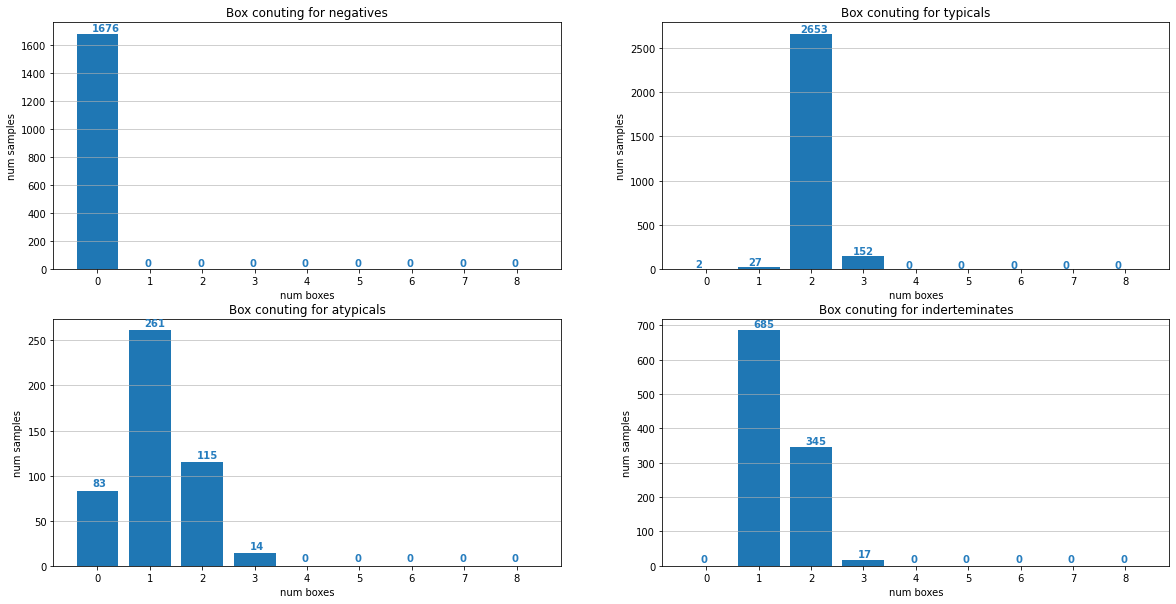

In [97]:
negatives_boxes_count = {}
typicals_boxes_count = {}
atypicals_boxes_count = {}
inderteminates_boxes_count = {}

for label in study_level_labels:
    for num_boxes in range(max(train_image_df['num_boxes'].unique())+1):
        if label == NEGATIVE:
            negatives_boxes_count[num_boxes] = len(train_df[((train_df['num_boxes'] == num_boxes) & (train_df[NEGATIVE] == 1))])
        if label == TYPICAL:
            typicals_boxes_count[num_boxes] = len(train_df[((train_df['num_boxes'] == num_boxes) & (train_df[TYPICAL] == 1))])
        if label == ATYPICAL:
            atypicals_boxes_count[num_boxes] = len(train_df[((train_df['num_boxes'] == num_boxes) & (train_df[ATYPICAL] == 1))])
        else:
            inderteminates_boxes_count[num_boxes] = len(train_df[((train_df['num_boxes'] == num_boxes) & (train_df[INDERTEMINATE] == 1))])

            
            
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
plot_frequency(axes[0,0], negatives_boxes_count, "Box conuting for negatives", "num boxes", "num samples", -0.1, 20)
plot_frequency(axes[0,1], typicals_boxes_count, "Box conuting for typicals", "num boxes", "num samples", -0.2, 20)
plot_frequency(axes[1,0], atypicals_boxes_count, "Box conuting for atypicals", "num boxes", "num samples", -0.1, 5)
plot_frequency(axes[1,1], inderteminates_boxes_count, "Box conuting for inderteminates", "num boxes", "num samples", -0.1, 10)

In [98]:
# remove outliers for typicals
train_df = train_df.drop(index=train_df[(train_df['int_label']==1)&(train_df['num_boxes']<2)].index)

<a id="section-six"></a>
## **Final train df**

**drop columns from df and remain only image id, study id, number of boxes, boxes, labels and image path**

In [99]:
train_df.columns

Index(['img_id', 'boxes', 'StudyInstanceUID', 'image_level',
       'confidence_scores', 'pascal_voc_boxes', 'coco_boxes', 'num_boxes',
       'dicom_path', 'negative', 'typical', 'indeterminate', 'atypical',
       'study_level', 'int_label', 'original_shape', 'Rows', 'Columns',
       'SOPClassUID', 'SOPInstanceUID', 'PatientID', 'PatientName',
       'PatientSex', 'PhotometricInterpretation', 'SamplesPerPixel',
       'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation',
       'ImageType', 'Modality', 'BodyPartExamined'],
      dtype='object')

In [100]:
train_df = train_df.drop(columns=['boxes', 'dicom_path', 'negative', 'typical', 'indeterminate', 'atypical',
                                  'Rows', 'Columns', 'SOPClassUID','SOPInstanceUID', 'PatientID', 'PatientName', 'PatientSex',
                                  'PhotometricInterpretation', 'SamplesPerPixel', 'BitsAllocated', 'BitsStored', 'HighBit', 
                                  'PixelRepresentation', 'ImageType', 'Modality', 'BodyPartExamined'])

In [101]:
train_df = train_df.rename(columns={'StudyInstanceUID':'study_id'})

**Add png paths**

In [102]:
train_df['png_path'] = np.nan
for index, row in train_df.iterrows():
    train_df.loc[index, 'png_path'] = '../input/siim-covid19-png-images/train/train/'+row['img_id']+'.png'

In [103]:
train_df.head()

,img_id,study_id,image_level,confidence_scores,pascal_voc_boxes,coco_boxes,num_boxes,study_level,int_label,original_shape,png_path
0,000a312787f2,5776db0cec75,opacity,"[1.0, 1.0]","[[789.28836, 582.43035, 1815.94498, 2499.73327...","[[789.28836, 582.43035, 1026.65662, 1917.30292...",2,typical,1,"(3488, 4256)",../input/siim-covid19-png-images/train/train/0...
1,000c3a3f293f,ff0879eb20ed,none,[1.0],"[[0.0, 0.0, 1.0, 1.0]]",NaN,0,negative,0,"(2320, 2832)",../input/siim-covid19-png-images/train/train/0...
2,0012ff7358bc,9d514ce429a7,opacity,"[1.0, 1.0]","[[677.42216, 197.97662, 1545.21983, 1197.75876...","[[677.42216, 197.97662, 867.79767, 999.78214],...",2,typical,1,"(2544, 3056)",../input/siim-covid19-png-images/train/train/0...
3,001398f4ff4f,28dddc8559b2,opacity,[1.0],"[[2729.0, 2181.33331, 3677.00012, 2785.33331]]","[[2729.0, 2181.33331, 948.00012, 604.0]]",1,atypical,3,"(3520, 4280)",../input/siim-covid19-png-images/train/train/0...
4,001bd15d1891,dfd9fdd85a3e,opacity,"[1.0, 1.0]","[[623.23328, 1050.0, 1337.23328, 2156.0], [257...","[[623.23328, 1050.0, 714.0, 1106.0], [2578.566...",2,typical,1,"(2800, 3408)",../input/siim-covid19-png-images/train/train/0...


In [104]:
train_df.to_csv(os.path.join(output_path, 'train_df.csv'), index=False)

In [105]:
len(train_df)

6001

<a id="section-seven"></a>
## **Create test df**

**Add image id, study id, image shape and image path**

In [7]:
def get_study_id(path):
    # dicom path of format '../input/siim-covid19-detection/test/study_id/dir/dicom_image'
    return path.split('/')[-3]

In [8]:
test_path = '../input/siim-covid19-detection/test'
paths = get_imgs_paths(test_path)

test_df = pd.DataFrame(np.nan, index=np.arange(len(paths)), columns=['img_id', 'dicom_path', 'study_id'])

imgs_id = []
studies_id = []
imgs_path = []
for img_id, path in paths.items():
    imgs_id.append(img_id)
    imgs_path.append(path)
    studies_id.append(get_study_id(path))
    
test_df['img_id'] = imgs_id
test_df['study_id'] = studies_id
test_df['dicom_path'] = imgs_path

In [9]:
test_df

,img_id,dicom_path,study_id
0,a29c5a68b07b,../input/siim-covid19-detection/test/2fb11712b...,2fb11712bc93
1,9850b5470fd6,../input/siim-covid19-detection/test/19c66935e...,19c66935e737
2,8d6dea06a032,../input/siim-covid19-detection/test/2fc50bf19...,2fc50bf199cd
3,dfc5c09a50bc,../input/siim-covid19-detection/test/97c5d6eb4...,97c5d6eb413d
4,7230234e120a,../input/siim-covid19-detection/test/593c3f815...,593c3f815635
...,...,...,...
1258,a43200bd5ceb,../input/siim-covid19-detection/test/b12d2e5c3...,b12d2e5c39b7
1259,37bf83df1b86,../input/siim-covid19-detection/test/648439329...,6484393291ea
1260,b30d2aef985f,../input/siim-covid19-detection/test/648439329...,6484393291ea
1261,a37a362df0ac,../input/siim-covid19-detection/test/531aa20ff...,531aa20ff7c3


In [17]:
shapes = []

for index, row in test_df.iterrows():
    img = get_img(row['dicom_path'])
    shapes.append(img.shape)

In [18]:
test_df['original_shape'] = shapes

In [19]:
test_df['png_path'] = np.nan
for index, row in test_df.iterrows():
    test_df.loc[index, 'png_path'] =  '../input/siim-covid19-png-images/test/test/'+row['img_id']+'.png'

In [20]:
test_df = test_df.drop(columns=['dicom_path'])

In [21]:
test_df.head()

,img_id,study_id,original_shape,png_path
0,a29c5a68b07b,2fb11712bc93,"(2320, 2828)",../input/siim-covid19-png-images/test/test/a29...
1,9850b5470fd6,19c66935e737,"(2330, 2382)",../input/siim-covid19-png-images/test/test/985...
2,8d6dea06a032,2fc50bf199cd,"(2422, 3344)",../input/siim-covid19-png-images/test/test/8d6...
3,dfc5c09a50bc,97c5d6eb413d,"(1140, 1387)",../input/siim-covid19-png-images/test/test/dfc...
4,7230234e120a,593c3f815635,"(2318, 2383)",../input/siim-covid19-png-images/test/test/723...


In [24]:
test_df.to_csv(os.path.join(output_path, 'test_df.csv'), index=False)

In [109]:
len(test_df)

1263